In [78]:
! ls -l data/Fruit-Images-Dataset-master/

total 32
-rw-r--r--  1 siddb users 1084 Sep 11 10:10 LICENSE
drwxr-xr-x  2 siddb users   48 Sep 11 10:10 papers
-rw-r--r--  1 siddb users 6582 Sep 11 10:10 readme.md
drwxr-xr-x  4 siddb users   45 Sep 11 10:10 src
drwxr-xr-x 83 siddb users 4096 Sep 11 10:10 Test
drwxr-xr-x  2 siddb users 4096 Sep 11 10:10 test-multiple_fruits
drwxr-xr-x 83 siddb users 4096 Sep 27 15:27 train
drwxr-xr-x 83 siddb users 4096 Sep 11 10:10 Training
drwxr-xr-x 83 siddb users 4096 Sep 27 15:27 val


In [1]:
import glob
import shutil
import errno
import os
from sklearn.model_selection import train_test_split

Download the fruits_360 data from https://github.com/Horea94/Fruit-Images-Dataset and store into the data folder. Then run the code below.



In [ ]:
dataset_base_dir = 'data/Fruit-Images-Dataset-master/'
training_images = glob.glob(os.path.join(dataset_base_dir, "Training", "*", '*.jp*g'))

The data does not contain a separate validation set, hence I randomly split 15% of the data into validation.

In [21]:
validation_split_perc = 0.15
train_samples, validation_samples = train_test_split(training_images, test_size=validation_split_perc)
len(train_samples), len(validation_samples)

(35123, 6199)

In [42]:
def copy_file(src, dest):
    try:
        shutil.copy(src, dest)
    except IOError as e:
        # ENOENT(2): file does not exist, raised also on missing dest parent dir
        if e.errno != errno.ENOENT:
            raise
        # try creating parent directories
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

Uncomment and run the cell below.

In [72]:
# Uncomment the below line and run for both train and val
#!mkdir data/Fruit-Images-Dataset-master/train #and val also
#!mkdir data/Fruit-Images-Dataset-master/val

In [73]:
for f in train_samples:
    copy_file(f, "data/Fruit-Images-Dataset-master/train/" + \
              os.path.basename(os.path.dirname(f)) + "/" + os.path.basename(f))
for f in validation_samples:
    copy_file(f, "data/Fruit-Images-Dataset-master/val/" + \
              os.path.basename(os.path.dirname(f)) +  "/" + os.path.basename(f))

##### Check that files have been copied

In [3]:
! ls -l data/Fruit-Images-Dataset-master/train/Apple\ Braeburn/ | head -10

total 3448
-rw-r--r-- 1 siddb users 4748 Sep 27 15:27 100_100.jpg
-rw-r--r-- 1 siddb users 4708 Sep 27 15:27 10_100.jpg
-rw-r--r-- 1 siddb users 4755 Sep 27 15:27 101_100.jpg
-rw-r--r-- 1 siddb users 4750 Sep 27 15:27 102_100.jpg
-rw-r--r-- 1 siddb users 4756 Sep 27 15:27 104_100.jpg
-rw-r--r-- 1 siddb users 4742 Sep 27 15:27 105_100.jpg
-rw-r--r-- 1 siddb users 4757 Sep 27 15:27 106_100.jpg
-rw-r--r-- 1 siddb users 4787 Sep 27 15:27 107_100.jpg
-rw-r--r-- 1 siddb users 4813 Sep 27 15:27 108_100.jpg
ls: write error: Broken pipe


Most of the VGG16 related code has been borrowed from the great tutorial here: https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch. Changes have been made to make the code Pytorch 0.4.1 compatible.



In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [5]:
## dataloaders

TRAIN = 'train'
VAL = 'val'
TEST = 'Test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(dataset_base_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 35123 images under train
Loaded 6199 images under val
Loaded 13877 images under Test
Classes: 
['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple M

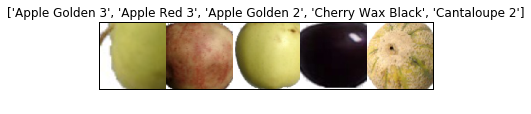

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
num_images_to_show = 5
#print(inputs[:num_images_to_show].shape, classes[:num_images_to_show])
show_databatch(inputs[:num_images_to_show], classes[:num_images_to_show])

In [7]:
#load vgg model
vgg16 = models.vgg16_bn(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [8]:
# Load the pretrained model from pytorch
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 81 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16) # check model has changed, output features

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(

In [9]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        #train_loader = tqdm(dataloaders[TRAIN], total=len(dataloaders[TRAIN]))
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 200 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            # Use half training dataset
            #if i >= train_batches / 20:
            #    break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            #print("1", labels.data, preds, loss, loss.data)
            #break
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes[TRAIN]
        avg_acc = acc_train  / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
        with torch.no_grad():    
            for i, data in enumerate(dataloaders[VAL]):
                if i % 100 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()


                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.item()
                acc_val += torch.sum(preds == labels).item()

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [13]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
torch.save(vgg16.state_dict(), 'VGG16_360_fruits_dataset.pt')

Epoch 0/5
----------
Training batch 4200/4391
Validation batch 700/775
Epoch 0 result: 
Avg loss (train): 0.0304
Avg acc (train): 0.9224
Avg loss (val): 0.0017
Avg acc (val): 0.9950
----------

Epoch 1/5
----------
Training batch 4200/4391
Validation batch 700/775
Epoch 1 result: 
Avg loss (train): 0.0201
Avg acc (train): 0.9470
Avg loss (val): 0.0019
Avg acc (val): 0.9927
----------

Epoch 2/5
----------
Training batch 4200/4391
Validation batch 700/775
Epoch 2 result: 
Avg loss (train): 0.0165
Avg acc (train): 0.9559
Avg loss (val): 0.0019
Avg acc (val): 0.9953
----------

Epoch 3/5
----------
Training batch 4200/4391
Validation batch 700/775
Epoch 3 result: 
Avg loss (train): 0.0146
Avg acc (train): 0.9606
Avg loss (val): 0.0012
Avg acc (val): 0.9940
----------

Epoch 4/5
----------
Training batch 4200/4391
Validation batch 700/775
Epoch 4 result: 
Avg loss (train): 0.0123
Avg acc (train): 0.9667
Avg loss (val): 0.0014
Avg acc (val): 0.9939
----------


Training completed in 62m 30s

In [21]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            if i % 100 == 0:
                print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

            #vgg.train(False)
            #vgg.eval()
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.item()
            acc_test += torch.sum(preds == labels).item()

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [22]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 1700/1735
Evaluation completed in 1m 3s
Avg loss (test): 0.0042
Avg acc (test): 0.9909
----------


We obtain a pretty good accuracy of 99.09% on the test set. Now lets see the performance on some data and visualize them. 

In [42]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0
    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.cpu(), labels.cpu())
        print("Prediction:")
        show_databatch(inputs.cpu(), predicted_labels)
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

Ground truth:


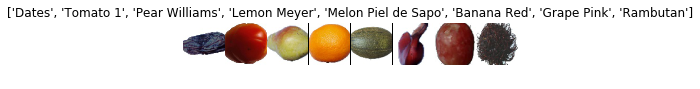

Prediction:


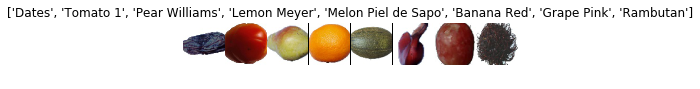

Ground truth:


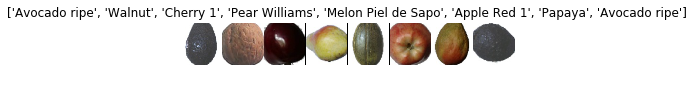

Prediction:


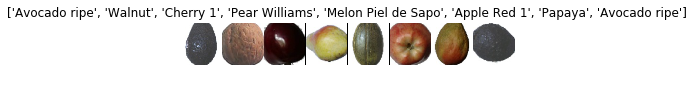

Ground truth:


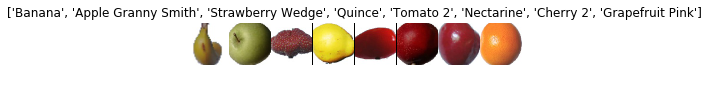

Prediction:


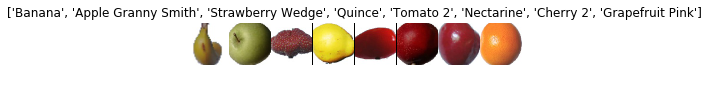

Ground truth:


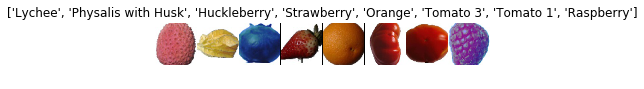

Prediction:


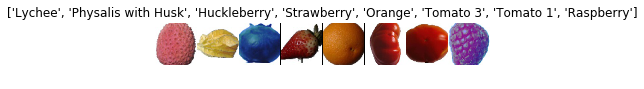

In [43]:
visualize_model(vgg16, num_images=32)

Not doing any confusiom matrix analysis further as it is straightforward by saving the labels and predictions. 